In [25]:
import os
import json

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from utils.exploratory import zip_dtype

from sklearn.linear_model import LinearRegression

In [26]:
plt.rcParams['figure.figsize'] = [24, 18]

In [27]:
def filter_ideb(ideb):
    cols_type_str = ['Co_UF', 'Nome_Municipio', 'Nome_Escola', 'Rede']
    for col in ideb:
        if col in cols_type_str:
            ideb[col] = ideb[col].astype('str')
        else:
            ideb[col] = ideb[col].astype(str).str.replace(',', '.').str.replace('*', '').str.replace('ND','NaN').astype(np.float64)
    return

def merge_ideb_to_frame(year, frame, ideb_iniciais, ideb_finais):
    if year < 2017 and year >= 2007:
        cols = ideb_iniciais.columns[ideb_iniciais.columns.str.match(r'Cod_Escola_Completo'+'|Ideb'+str(year)+'|Ideb'+str(year+2))]
        ideb_iniciais_ano = ideb_iniciais[cols]
        ideb_iniciais_ano['diff_'+str(year)] = ideb_iniciais_ano['Ideb'+str(year+2)] - ideb_iniciais_ano['Ideb'+str(year)]
    
        cols = ideb_finais.columns[ideb_finais.columns.str.match(r'Cod_Escola_Completo'+'|Ideb'+str(year)+'|Ideb'+str(year+2))]
        ideb_finais_ano = ideb_finais[cols]
        ideb_finais_ano['diff_'+str(year)] = ideb_finais_ano['Ideb'+str(year+2)] - ideb_finais_ano['Ideb'+str(year)]

    elif year == 2017:
        cols = ideb_iniciais.columns[ideb_iniciais.columns.str.match(r'Cod_Escola_Completo'+'|Ideb'+str(year))]
        ideb_iniciais_ano = ideb_iniciais[cols]
        
        cols = ideb_finais.columns[ideb_finais.columns.str.match(r'Cod_Escola_Completo'+'|Ideb'+str(year))]
        ideb_finais_ano = ideb_finais[cols]

    else:
        return None
    
    frame_merge = frame.merge(ideb_iniciais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['','']).drop('Cod_Escola_Completo', axis=1)
    frame_merge = frame_merge.merge(ideb_finais_ano, left_on='cod_escola_inep', right_on='Cod_Escola_Completo', how='left', suffixes=['','_final']).drop('Cod_Escola_Completo', axis=1)

    return frame_merge

def load_escolas(year):
    escolas = pd.read_csv('../data/escolas/escolas' + str(year) + '0101.csv',
                               dtype=zip_dtype('../schemas/escolas_schema.json'))
    escolas['cod_escola_inep'] = escolas['cod_escola_inep'].astype(np.float64)
    constant_columns = escolas.apply(lambda x: is_constant(x))
    escolas = escolas.drop(constant_columns[constant_columns==True].index, axis=1)
    escolas = escolas[escolas['tp_rede'].str.lower() != 'privada']
    escolas = escolas[escolas['tp_rede_publica'] == True]
    
    return escolas

def clean_escola(escolas):
    to_remove = []
    to_int = []    
    for col in escolas.columns:
        col_type = escolas[col].dtype

        if col_type == 'object':
            to_remove.append(col)
        elif col_type == 'bool':
            to_int.append(col)

    escolas = escolas.drop(to_remove,axis=1)
    escolas[to_int] = escolas[to_int].astype(np.float64)
    
    return escolas

def is_constant(x):
   try:
       x = x.values
   except AttributeError:
       pass

   return (x == x[0]).all()

def load_ideb_escolas(iniciais): # iniciais: True or False
    if iniciais:
        age = 'iniciais'
    else:
        age = 'finais'
    ideb = pd.read_csv('../data/ideb/ideb_escolas_anos'+age+'2005_2017.csv', encoding='latin1', na_values=['-', 'ND','ND**'])
    filter_ideb(ideb)
    ideb['Cod_Municipio_Completo'] = ideb['Cod_Municipio_Completo'].astype(np.float64)
    return ideb

In [28]:
ideb_iniciais = load_ideb_escolas(True)
ideb_finais   = load_ideb_escolas(False)

D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (64,65,67,68,70,71) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):
D:\Programs\Anaconda3\envs\torch\lib\site-packages\IPython\core\interactiveshell.py:2903: DtypeWarning: Columns (60,61,63,64) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [29]:
ideb_iniciais.columns

Index(['Co_UF', 'Cod_Municipio_Completo', 'Nome_Municipio',
       'Cod_Escola_Completo', 'Nome_Escola', 'Rede',
       'TaxaAprovacao2005_1ao5ano', 'TaxaAprovacao2005_1ano',
       'TaxaAprovacao2005_2ano', 'TaxaAprovacao2005_3ano',
       'TaxaAprovacao2005_4ano', 'TaxaAprovacao2005_5ano',
       'IndicadorRendimento_2005', 'TaxaAprovacao2007_1ao5ano',
       'TaxaAprovacao2007_1ano', 'TaxaAprovacao2007_2ano',
       'TaxaAprovacao2007_3ano', 'TaxaAprovacao2007_4ano',
       'TaxaAprovacao2007_5ano', 'IndicadorRendimento_2007',
       'TaxaAprovacao2009_1ao5ano', 'TaxaAprovacao2009_1ano',
       'TaxaAprovacao2009_2ano', 'TaxaAprovacao2009_3ano',
       'TaxaAprovacao2009_4ano', 'TaxaAprovacao2009_5ano',
       'IndicadorRendimento_2009', 'TaxaAprovacao2011_1ao5ano',
       'TaxaAprovacao2011_1ano', 'TaxaAprovacao2011_2ano',
       'TaxaAprovacao2011_3ano', 'TaxaAprovacao2011_4ano',
       'TaxaAprovacao2011_5ano', 'IndicadorRendimento_2011',
       'TaxaAprovacao2013_1ao5ano', 'Taxa

In [30]:
select_columns_raw = [column for column in ideb_iniciais.columns if not (column.startswith('Ideb') or column.startswith('Cod_Escola_Completo'))]
ideb_iniciais = ideb_iniciais.drop(select_columns_raw, axis=1)
select_columns_raw = [column for column in ideb_finais.columns if not (column.startswith('Ideb') or column.startswith('Cod_Escola_Completo'))]
ideb_finais = ideb_finais.drop(select_columns_raw, axis=1)

In [31]:
_suffix = 'Delta_'
for ano in [2005,2007,2009,2011,2013,2015] :
    ideb_iniciais[_suffix+str(ano)] = ideb_iniciais['Ideb'+str(ano+2)] - ideb_iniciais['Ideb'+str(ano)]
    ideb_finais[_suffix+str(ano)] = ideb_finais['Ideb'+str(ano+2)] - ideb_finais['Ideb'+str(ano)]

In [32]:
merged = ideb_finais.merge(ideb_iniciais, on='Cod_Escola_Completo', how='inner', suffixes=['_finais','_iniciais'])

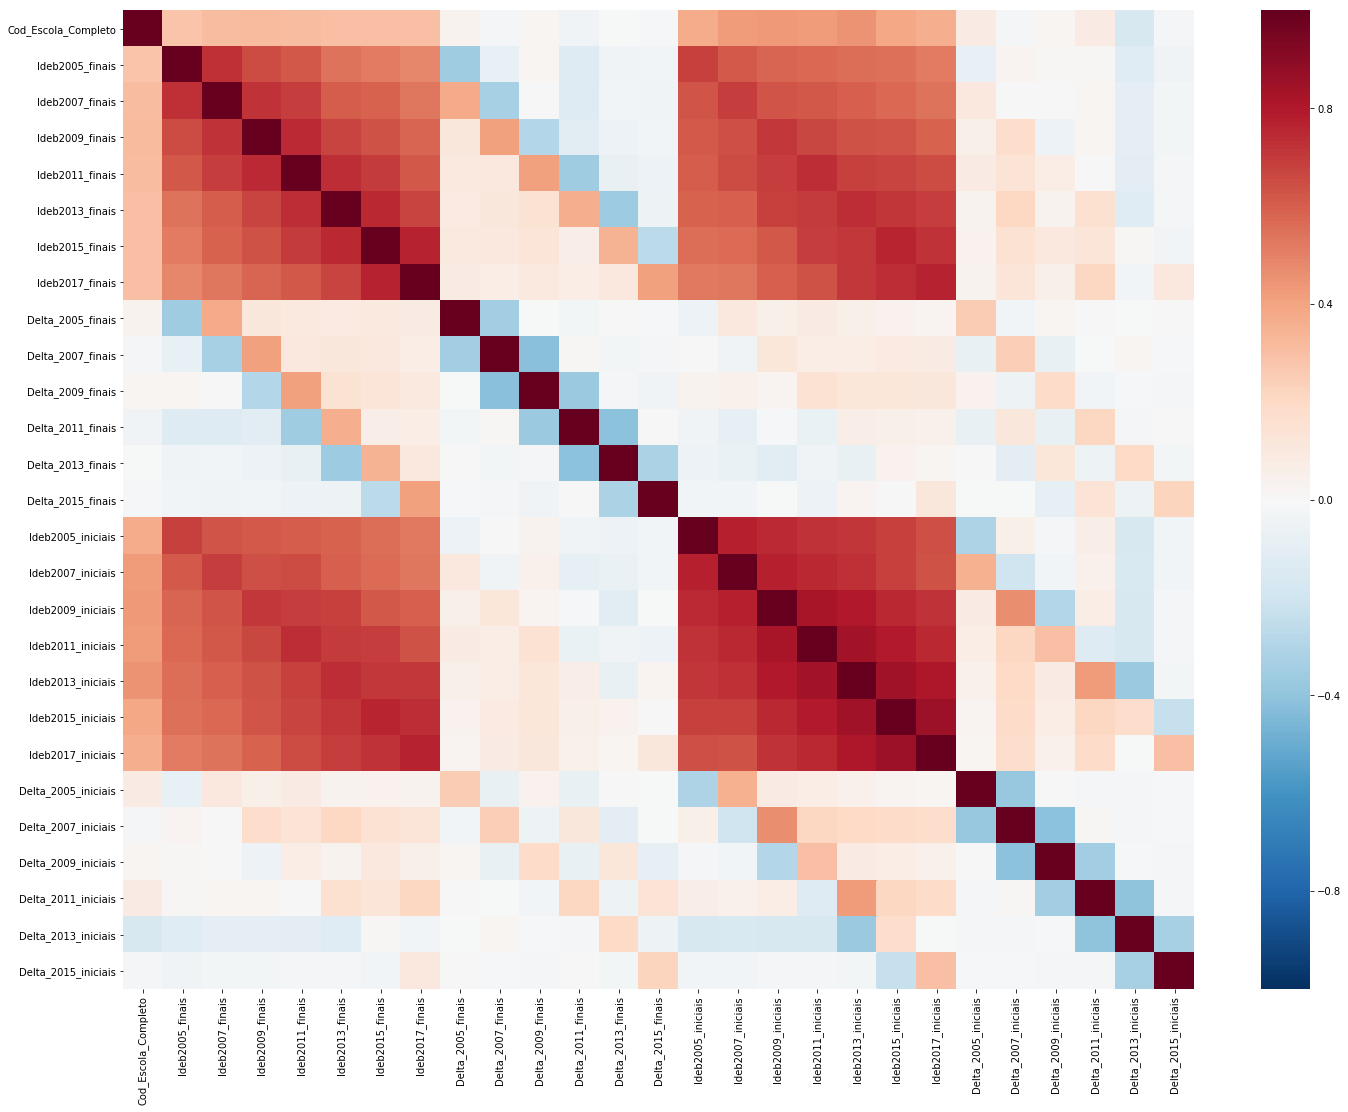

In [33]:
corr_ma = merged.corr().fillna(0.0)
sns.heatmap(corr_ma, vmin=-1, vmax=1, cmap='RdBu_r')

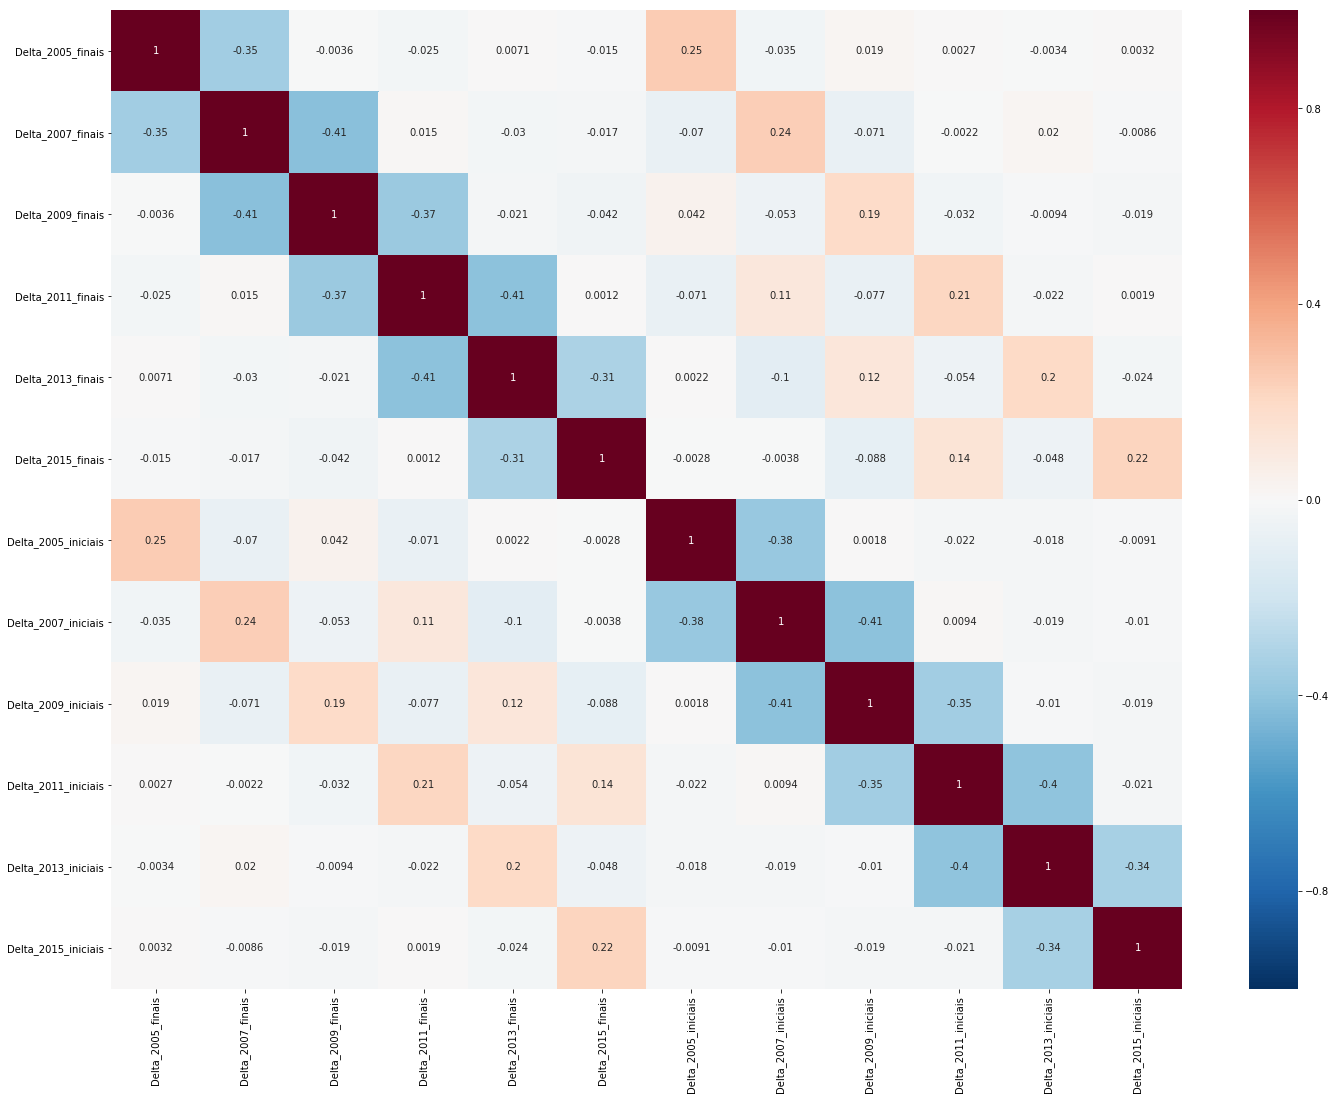

In [34]:
corr_ma = merged.drop([col for col in merged.columns if not col.startswith(_suffix)],axis=1).corr().fillna(0.0)
sns.heatmap(corr_ma, vmin=-1, vmax=1, cmap='RdBu_r', annot=True)

In [35]:
corr_ma

Delta_2005_finais  Delta_2007_finais  Delta_2009_finais  \
Delta_2005_finais             1.000000          -0.350455          -0.003606   
Delta_2007_finais            -0.350455           1.000000          -0.414839   
Delta_2009_finais            -0.003606          -0.414839           1.000000   
Delta_2011_finais            -0.024778           0.014534          -0.368183   
Delta_2013_finais             0.007136          -0.030100          -0.020814   
Delta_2015_finais            -0.015421          -0.017230          -0.041598   
Delta_2005_iniciais           0.250190          -0.070422           0.041648   
Delta_2007_iniciais          -0.035054           0.244368          -0.052938   
Delta_2009_iniciais           0.018585          -0.071253           0.189747   
Delta_2011_iniciais           0.002652          -0.002209          -0.032161   
Delta_2013_iniciais          -0.003388           0.020049          -0.009381   
Delta_2015_iniciais           0.003202          -0.008585          -0.019442   

                     Delta_2011_finais  Delta_2013_finais  Delta_2015_finais  \
Delta_2005_finais            -0.024778           0.007136          -0.015421   
Delta_2007_finais             0.014534          -0.030100          -0.017230   
Delta_2009_finais            -0.368183          -0.020814          -0.041598   
Delta_2011_finais             1.000000          -0.410873           0.001184   
Delta_2013_finais            -0.410873           1.000000          -0.313591   
Delta_2015_finais             0.001184          -0.313591           1.000000   
Delta_2005_iniciais          -0.071124           0.002193          -0.002778   
Delta_2007_iniciais           0.111909          -0.103714          -0.003813   
Delta_2009_iniciais          -0.076538           0.120605          -0.087901   
Delta_2011_iniciais           0.211887          -0.053507           0.138542   
Delta_2013_iniciais          -0.021538           0.197073          -0.047756   
Delta_2015_iniciais           0.001944          -0.024004           0.220154   

                     Delta_2005_iniciais  Delta_2007_iniciais  \
Delta_2005_finais               0.250190            -0.035054   
Delta_2007_finais              -0.070422             0.244368   
Delta_2009_finais               0.041648            -0.052938   
Delta_2011_finais              -0.071124             0.111909   
Delta_2013_finais               0.002193            -0.103714   
Delta_2015_finais              -0.002778            -0.003813   
Delta_2005_iniciais             1.000000            -0.378318   
Delta_2007_iniciais            -0.378318             1.000000   
Delta_2009_iniciais             0.001804            -0.406885   
Delta_2011_iniciais            -0.022078             0.009358   
Delta_2013_iniciais            -0.017698            -0.018568   
Delta_2015_iniciais            -0.009108            -0.010032   

                     Delta_2009_iniciais  Delta_2011_iniciais  \
Delta_2005_finais               0.018585             0.002652   
Delta_2007_finais              -0.071253            -0.002209   
Delta_2009_finais               0.189747            -0.032161   
Delta_2011_finais              -0.076538             0.211887   
Delta_2013_finais               0.120605            -0.053507   
Delta_2015_finais              -0.087901             0.138542   
Delta_2005_iniciais             0.001804            -0.022078   
Delta_2007_iniciais            -0.406885             0.009358   
Delta_2009_iniciais             1.000000            -0.351178   
Delta_2011_iniciais            -0.351178             1.000000   
Delta_2013_iniciais            -0.010194            -0.401069   
Delta_2015_iniciais            -0.018867            -0.021226   

                     Delta_2013_iniciais  Delta_2015_iniciais  
Delta_2005_finais              -0.003388             0.003202  
Delta_2007_finais               0.020049            -0.008585  
Delta_2009_finais              -0.009381            -0.

In [57]:
plt.rcParams['figure.figsize'] = [16, 8]
to_drop = [col for col in merged.columns if not col.startswith(_suffix)]
merged_c = merged.drop(to_drop, axis=1)

In [58]:
focus_cols = [_suffix+'2005_iniciais', _suffix+'2007_iniciais', _suffix+'2009_iniciais', _suffix+'2011_iniciais', _suffix+'2013_iniciais', _suffix+'2015_iniciais']
corr_mac = merged_c.corr().fillna(0.0).drop(focus_cols).filter(focus_cols)

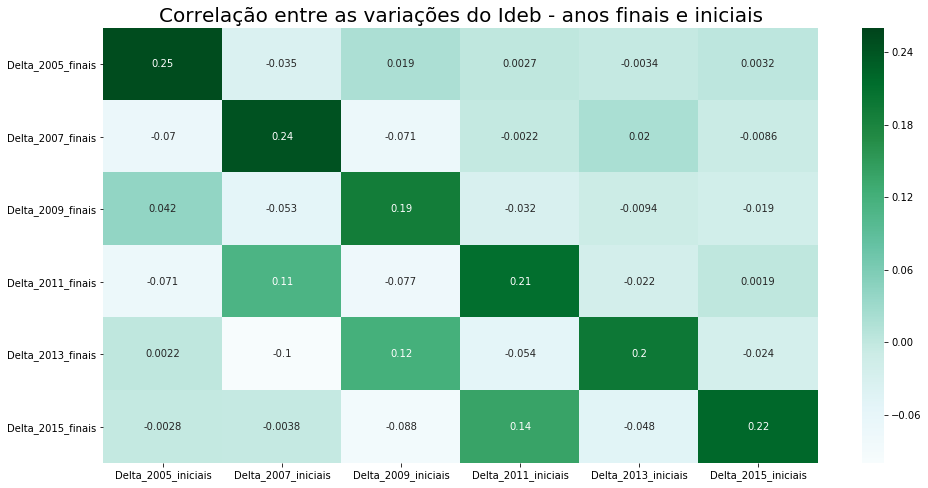

In [65]:
sns.heatmap(corr_mac, vmin=-0.1, vmax=0.26, cmap='BuGn', annot=True)
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.title('Correlação entre as variações do Ideb - anos finais e iniciais', fontsize=20)
plt.savefig('corr.png')